In [1]:
import pandas as pd

df = pd.read_csv(
    "../data/processed/traffic_features.csv",
    parse_dates=["timestamp"],
    index_col="timestamp"
)

df.head()


,traffic_flow,hour,day_of_week,is_weekend,lag_1,lag_3,lag_6,lag_12,lag_24,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,roll_mean_24,roll_std_24
timestamp,,,,,,,,,,,,,,,
2017-01-01 02:00:00,62.813790,2,6,1,67.012016,66.181734,65.359890,65.465191,65.831430,63.824131,2.237779,63.960167,1.672746,64.016883,1.985902
2017-01-01 02:05:00,67.492250,2,6,1,62.813790,62.058451,61.619649,63.235851,65.468198,64.802898,2.361598,64.314866,1.935790,64.101219,2.090441
2017-01-01 02:10:00,61.117262,2,6,1,67.492250,67.012016,63.259146,62.944482,65.468198,64.445917,2.768460,64.162598,2.116785,63.919930,2.154422
2017-01-01 02:15:00,65.200000,2,6,1,61.117262,62.813790,66.181734,63.998413,65.468198,64.282295,2.672706,64.262730,2.136640,63.908755,2.146724
2017-01-01 02:20:00,40.900000,2,6,1,65.200000,67.492250,62.058451,65.381665,65.468198,60.755886,10.028855,62.222592,7.037798,62.885080,5.140694


train test split 

In [2]:
split_date = df.index[int(len(df) * 0.8)]

train = df.loc[:split_date]
test = df.loc[split_date:]

X_train = train.drop("traffic_flow", axis=1)
y_train = train["traffic_flow"]

X_test = test.drop("traffic_flow", axis=1)
y_test = test["traffic_flow"]


In [3]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (8909, 14) (8909,)
Test shape: (2228, 14) (2228,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
from sklearn.linear_model import Ridge

linear_model = Ridge(alpha=1.0, random_state=42)
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)


In [6]:
from sklearn.ensemble import RandomForestRegressor

tree_model = RandomForestRegressor(n_estimators=100, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)


 Neural Network Model

In [7]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)


In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MSE: {mse:.2f}, R2: {r2:.4f}")

evaluate_model(y_test, y_pred_linear, "Ridge Regression")
evaluate_model(y_test, y_pred_tree, "Random Forest")
evaluate_model(y_test, y_pred_nn, "MLP Regressor")


Ridge Regression -> MSE: 6.13, R2: 0.6042
Random Forest -> MSE: 6.71, R2: 0.5668
MLP Regressor -> MSE: 6.39, R2: 0.5878


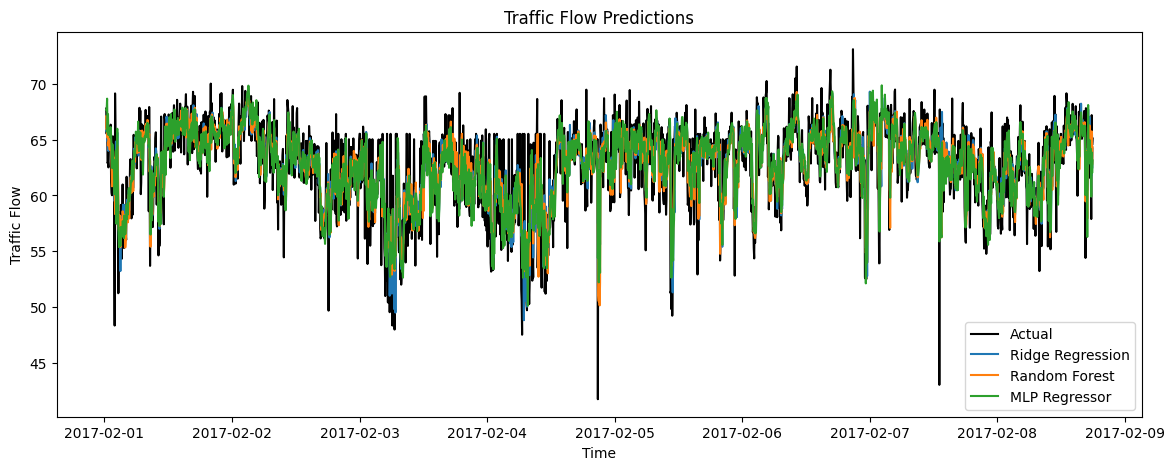

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", color='black')
plt.plot(y_test.index, y_pred_linear, label="Ridge Regression")
plt.plot(y_test.index, y_pred_tree, label="Random Forest")
plt.plot(y_test.index, y_pred_nn, label="MLP Regressor")
plt.xlabel("Time")
plt.ylabel("Traffic Flow")
plt.title("Traffic Flow Predictions")
plt.legend()
plt.show()


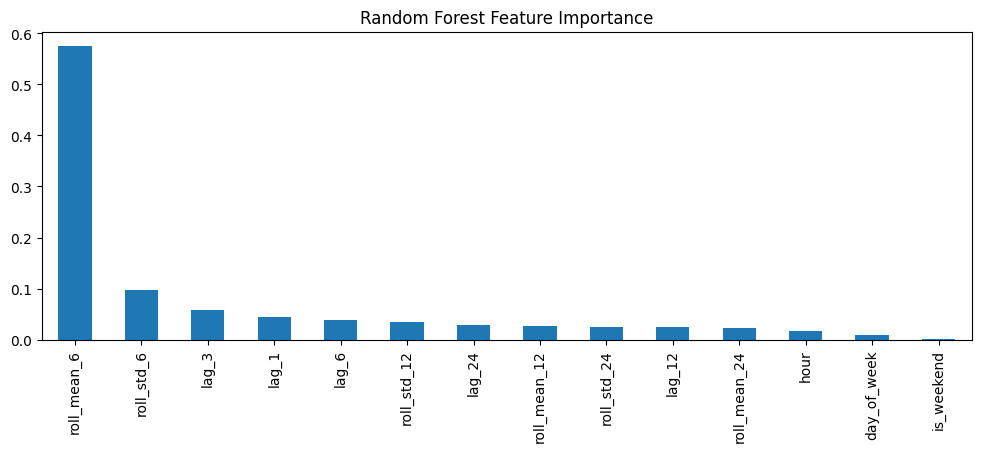

In [10]:
import pandas as pd

feat_importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,4))
plt.title("Random Forest Feature Importance")
plt.show()


Model Comparison Summary :

I trained three different models representing different learning paradigms:

Ridge Regression (linear model)

Random Forest Regressor (tree-based model)

MLP Regressor (neural network)

The models were evaluated using Mean Squared Error (MSE) and R² score on a time-based holdout test set.

In [11]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Ridge Regression", "Random Forest", "MLP Regressor"],
    "MSE": [6.13, 6.71, 6.39],
    "R2 Score": [0.6042, 0.5668, 0.5878]
})

results


,Model,MSE,R2 Score
0,Ridge Regression,6.13,0.6042
1,Random Forest,6.71,0.5668
2,MLP Regressor,6.39,0.5878


# Best Performing Model



Among the evaluated models, Ridge Regression achieved the lowest MSE (6.13) and the highest R² score (0.6042).
This suggests that the relationship between the selected traffic and weather features and traffic flow is largely linear, and regularization helps improve generalization.

# Visualization: actual vs predicted (best model)

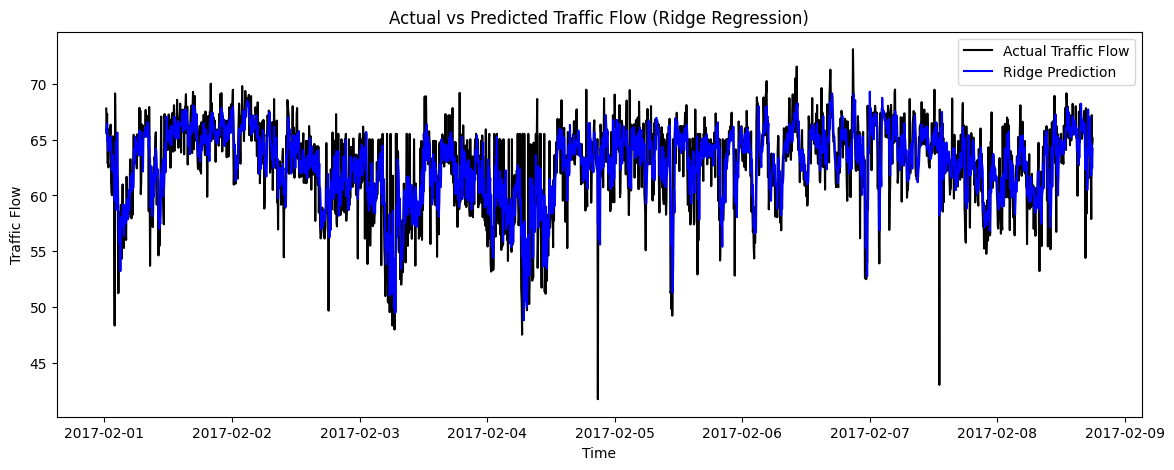

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual Traffic Flow", color="black")
plt.plot(y_test.index, y_pred_linear, label="Ridge Prediction", color="blue")
plt.xlabel("Time")
plt.ylabel("Traffic Flow")
plt.title("Actual vs Predicted Traffic Flow (Ridge Regression)")
plt.legend()
plt.show()


# **Error Analysis **

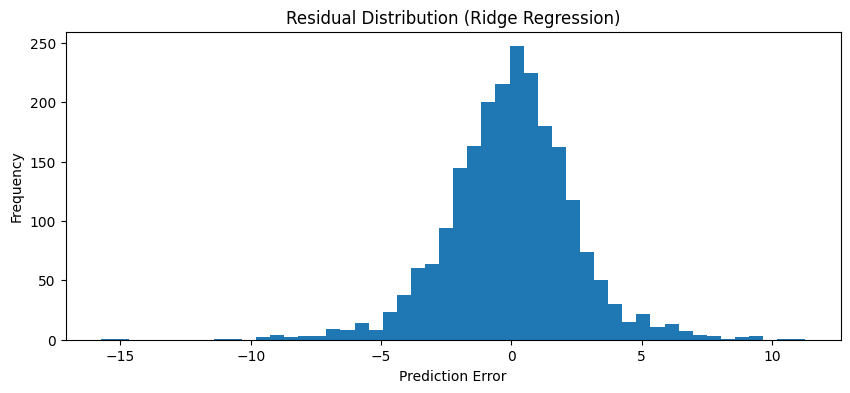

In [13]:
residuals = y_test - y_pred_linear

plt.figure(figsize=(10,4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (Ridge Regression)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


**Conclusion**

This study evaluated multiple machine learning models for short-term traffic flow prediction using traffic and weather features.
Among the tested models, Ridge Regression demonstrated the best performance, indicating that linear relationships with regularization are effective for this dataset.
Future work may explore spatio-temporal models or deep learning approaches such as LSTMs or graph neural networks to further improve prediction accuracy.